#### Forecasting European yields

In [3]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from tshistory.api import timeseries
tsa = timeseries('http://tst-qdev-ap9.petroineos.local/api/')
def get_multi(dict_series):
    data = pd.concat(map(tsa.get, dict_series.values()), axis=1)
    data.columns = dict_series.keys()
    return data
figsize = (7, 5)
tickers = {
    'diesel_yield': 'diesel.jodi.oecd_europe.yield.pct.monthly',
    'distillate_yield': 'distillates.iea.oecd_europe.refining_yield.pct.monthly',
    'total_outage': 'oil.petroineos.oecd_europe.cdu.total_outage.kbd.monthly',
    'capacity': 'oil.petroineos.oecd_europe.cdu.capacity.kbd.daily',
    'gasoline_diesel': 'nwe_gasoline_diesel_spread.usd_bbl',
    'hck': 'price.argus.nwe_net_hydrocracking_margin_50_pct.usd_bbl.daily',
    'fcc': 'price.argus.nwe_net_fcc_margin.usd_bbl.daily',
    'runs': 'oil.petroineos.oecd_europe.cdu_utilization_rate.pct.monthly.full',
    'ea': 'crude.energy_aspects.oecd_europe.throughput.kbd.monthly',
}

In [4]:
data = get_multi(tickers).resample('MS').mean()

In [5]:
data['outage_pct'] = data['total_outage'] / data['capacity']
data['runs2'] = data['runs'] ** 2
data['druns'] = data['runs'].diff()
data['hck_fcc_margin'] = (data['hck'] - data['fcc'])
data['cat_spread'] = pd.cut(data['gasoline_diesel'].shift(1), bins=3, labels=["low", "medium", 'high']).dropna()
dummies = pd.get_dummies(data['cat_spread'])
for x in dummies.columns:
    data[x] = dummies[x]

#### Runs are the main driver of diesel yields 
* Logic when considering that the marginal barrel refined outputs increasingly strait run products, as a topping refinery
* It is not very dependant on the turnaround intensity.

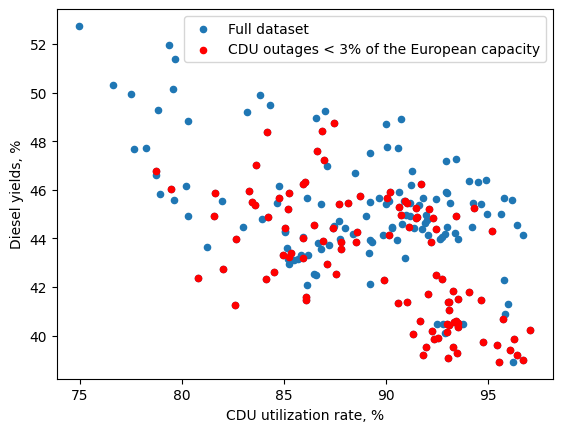

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
model = sm.formula.ols("diesel_yield ~ runs", data=data).fit()
model2 = sm.formula.ols("diesel_yield ~ runs + I(runs ** 2)", data=data).fit()
(data[['runs', 'diesel_yield', 'outage_pct']] * 100).plot.scatter(x = 'runs', y = 'diesel_yield', ax=ax,label="Full dataset")
(data[['runs', 'diesel_yield', 'outage_pct']] * 100).query("outage_pct < 3.4701").plot.scatter(x = 'runs', y = 'diesel_yield', ax=ax, color='red', label="CDU outages < 3% of the European capacity")
plt.ylabel("Diesel yields, %")
plt.xlabel("CDU utilization rate, %")
pass

#### Fitting a local linear model with seasonality, autoregressive and price drivers
* We observer seasonality and autocorrelation in the residual of the simple OLS regression with runs and a constant trend, hence our choice.
* Its too hard to fit ouright gasoline/diesel spreads, we split prices in 3 tiers, low, medium and high gasoline - diesel spread.

In [12]:
exog_vars = [
    'runs', 
    'runs2',
    'druns',
    # 'hck_fcc_margin',
    'low', 
    'medium', 
    'high'
]
_vars = exog_vars + ['diesel_yield']
endog = data[_vars]['2005-1-1':].dropna(axis=0)
umodel = sm.tsa.UnobservedComponents(
    endog=endog['diesel_yield'], 
    exog=endog[exog_vars], 
    level='irregular',
    seasonal=12,
    autoregressive=4,
    stochastic_seasonal = False,
    mle_regression = True,
)
fitted = umodel.fit(
    method="powell", maxiter=10_000
)
data['unexplained'] = fitted.resid.iloc[13:]
data = data.iloc[1:]
fitted.summary()

Optimization terminated successfully.
         Current function value: -3.166915
         Iterations: 11
         Function evaluations: 1634


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:           diesel_yield   No. Observations:                  222
Model:                      irregular   Log Likelihood                 703.055
                       + seasonal(12)   AIC                          -1382.110
                              + AR(4)   BIC                          -1341.888
Date:                Fri, 01 Sep 2023   HQIC                         -1365.851
Time:                        15:09:25                                         
Sample:                    01-01-2005                                         
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.956e-05   1.11e-05      1.757      0.079   -2.25e-06    4.14e-05
sigma2.ar         3.117e-05   1.81e-05      1.726      0.084   -4.22e-06    6.66e-05
ar.L1                0.8756      0.272      3.223      0.001       0.343       1.408
ar.L2                0.0287      0.260      0.111      0.912      -0.480       0.538
ar.L3               -0.1250      0.248     -0.504      0.614      -0.611       0.361
ar.L4                0.2085      0.141      1.473      0.141      -0.069       0.486
beta.runs            1.0992      0.097     11.339      0.000       0.909       1.289
beta.runs2          -0.6936      0.065    -10.702      0.000      -0.821      -0.567
beta.druns           0.0276      0.024      1.152      0.250      -0.019       0.075
beta.low             0.0103      0.009      1.206      0.228      -0.006       0.027
beta.medium          0.0015      0.007      0.208      0.835      -0.013       0.015
beta.high            0.0031      0.007      0.413      0.680      -0.012       0.018
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               133.31
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.27   Skew:                             0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

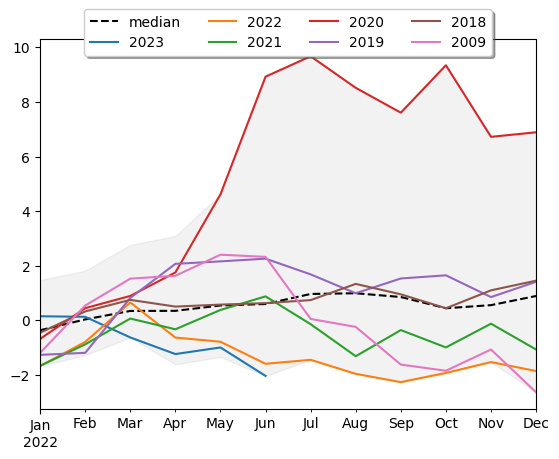

In [13]:
fig, ax = plt.subplots()
stats = data['unexplained'].groupby([data.index.year, data.index.month]).mean().unstack(0).cumsum().agg(['min', 'median', 'max'], axis=1) * 100
stats.index = pd.to_datetime(stats.index, format="%m") + pd.DateOffset(years=2022-1900)
stats['median'].plot(color='black', ax=ax, linestyle="--")
ax.fill_between(stats.index, stats['min'], stats['max'], alpha=0.1, color='grey')
per_year = data['unexplained'].groupby([data.index.year, data.index.month]).mean().unstack(0)[[2023, 2022, 2021, 2020, 2019, 2018, 2009]].cumsum() * 100
per_year.index = pd.to_datetime(per_year.index, format="%m") + pd.DateOffset(years=2022-1900)
per_year.plot(ax=ax)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=4, fancybox=True, shadow=True)
pass

In [14]:
endog = data[_vars]['2005-1-1':].dropna(axis=0,subset=exog_vars)

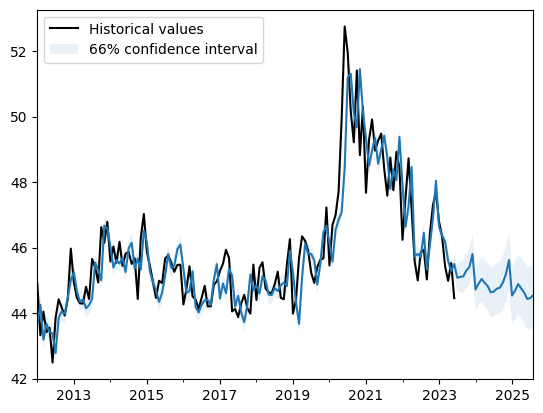

In [15]:
fitted2 = fitted.apply(
    endog=endog['diesel_yield'], 
    exog=endog[exog_vars], 
)
fcst = fitted2.smoother_results.forecasts
std = np.abs(fitted2.smoother_results.smoothed_forecasts_error_cov[0]) ** 0.5
first_date = '2012-1-1'
res = pd.DataFrame(
    np.concatenate((fcst, fcst + 0.5 * std, fcst - 0.5 * std),axis=0).T, 
    columns=['mean', "sigma", "-sigma"], 
    index=fitted2.model.data.dates)[first_date:] * 100
fig, ax = plt.subplots()
(data['diesel_yield'][first_date:].dropna() * 100).plot(ax=ax, color='black', label="Historical values")
res['mean'].plot(ax=ax, label="")
ax.fill_between(res.index, res["sigma"], res["-sigma"],alpha=0.1, label="66% confidence interval")
res.columns = [f"diesel.jodi.petroineos.yield.forecast.pct.monthly.{x}" for x in res.columns]
ax.legend()
pass

In [16]:
for x in res.columns:
    tsa.update(
        x,
        res[x] / 100,
        author='loicballand'
    )